In [35]:
%pylab inline
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import seaborn as sea

Populating the interactive namespace from numpy and matplotlib


# Importación y procesamiento de datos

In [36]:
data= pd.DataFrame(pd.read_csv("wine.data", header = None))
data.columns = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
target = data["Class"]
del data["Class"]
scaled_data = preprocessing.scale(data) #Desviacion estandar = 1 y promedio = 0

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, target)

#K-means clustering 

In [38]:
from sklearn.cluster import KMeans

##Optimización de parámetros del modelo

In [39]:
errors_km = np.zeros(10)
for i in range(1,11):
    fit_K  = KMeans(n_clusters = i).fit(X_train, Y_train)
    errors_km[i-1] = fit_K.inertia_    

El error en este caso se define como la distancia total que hay entre los todos los puntos y el centro del cluster más cercano 

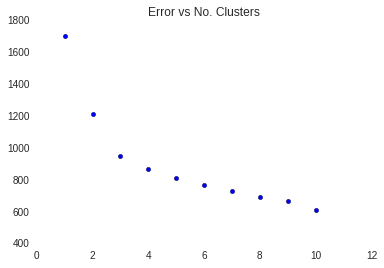

In [40]:
x = linspace(1, 10, 10)
scatter(x, errors_km)
title("Error vs No. Clusters")

Se puede ver que al llegar a tres clusters el error disminuye en menor medida cuando se aumenta el número de clusters. Es por esto que el número de clusters óptimo para esta caso sería tres.

##Clasificación

In [41]:
km = KMeans(n_clusters = 3)
fit = km.fit(X_train, Y_train)
predict_km = km.predict(X_test)

##Validación de KMeans Clustering

Teniendo en cuenta que la predicción de kmeans consiste en agrupar los puntos al cluster más cercano, no se puede hacer una comparación directa entre los labels dados por la función predict() y el target del dataset. Es por esto que para encontrar qué proporción de puntos fue clasificado correctamente se mostrarán gráficas en las que se podrán ver cuántos puntos fueron clasificados de manera incorrecta.

In [42]:
index_km = Y_test.index.values
results_km = pd.concat([Y_test, pd.DataFrame(data =predict_km, index = index_km, columns = ["Cluster"])], axis=1)

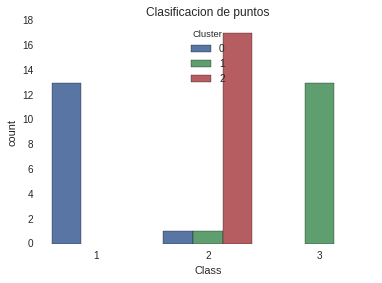

In [43]:
sea.countplot(x= "Class", hue = "Cluster", data= results_km)
title("Clasificacion de puntos")

En la gráfica se puede ver que únicamente se clasificaron incorrectamente dos puntos.

#PCA

In [52]:
from sklearn.decomposition import PCA

##Optimización de parámetros del modelo

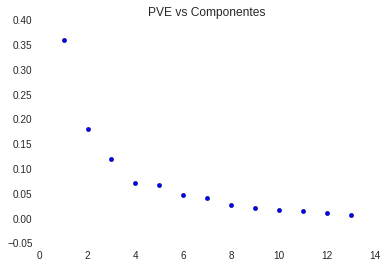

In [53]:
fit_PCA_test = PCA().fit(X_train, Y_train)
PVE = fit_PCA_test.explained_variance_ratio_
scatter(range(1,14),PVE)
title("PVE vs Componentes")

Como se quiere explicar el 95% de la varianza, se puede ver en la gráfica que serán necesarias 4 componentes. Sin embargo, se puede ver que después de la tercera componente cada una de las componentes explica menos del 5%. Esto se observa en la forma en la que la gráfica tiende a saturarse después de la tercera componenente. Es por esto que el número óptimo de componentes sería tres.

##Clasificación

Es importante anotar que no se puede usar únicamente PCA para clasificación. Es por esto que se usará una reducción de dimensiones usando PCA y después se clasificará usando KMeans clustering.

In [54]:
fit_PCA = PCA(n_components = 3)
fit_PCA.fit(scaled_data)
PCA_result = fit_PCA.transform(scaled_data)

In [55]:
scaled_PCA = preprocessing.scale(PCA_result)
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(scaled_PCA, target)

In [56]:
km_pca = KMeans(n_clusters = 3)
fit_pca_km = km.fit(X_train_pca, Y_train_pca)
predict_km_pca = km.predict(X_test_pca)

##Validación de PCA con KMeans clustering

In [57]:
index_km_pca = Y_test_pca.index.values
results_km_pca = pd.concat([Y_test_pca, pd.DataFrame(data =predict_km_pca, index = index_km_pca, columns = ["Cluster"])], axis=1)

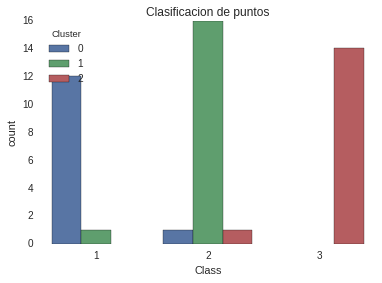

In [58]:
sea.countplot(x= "Class", hue = "Cluster", data= results_km_pca)
title("Clasificacion de puntos")

#Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

##Optimización de parámetros del modelo

In [65]:
n_trees_total = 50
error_rf = np.zeros(n_trees_total)
m = 3 #Se toma como el numero de predictores como sqrt(p)
for i in range(1,n_trees_total+1):
    rf_test = RandomForestClassifier(n_estimators = n_trees_total, max_features =  m)
    fit = rf_test.fit(X_train, Y_train)
    error_rf[i-1] = fit.oob_score

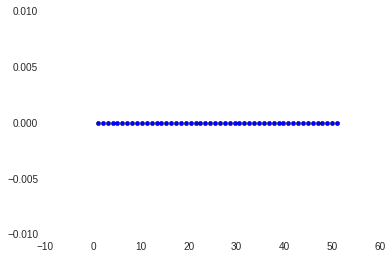

In [66]:
x = linspace(1, n_trees_total+1, n_trees_total)
scatter(x, error_rf)

La gráfica sugiere que sin importar el número de árboles se logrará una clasificación perfecta de los datos de entrenamiento.

##Clasificación

In [67]:
rf = RandomForestClassifier(n_estimators=n_trees_total, max_features=3)
fit_rf = rf.fit(X_train, Y_train) 
predict_rf = rf.predict(X_test)

##Validación RandomForestClassifier

In [76]:
good_class_rf = 0
for i in range(len(predict_rf)):
    if predict_rf[i] == Y_test.iloc[i]:
        good_class_rf += 1
eff_rf = float(good_class_rf)/float(len(predict_rf))
print("Eficiencia Random Forest:{0:.2f}%".format(eff_rf*100))

Eficiencia Random Forest:97.78%


#SVM